<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/course_part_2/01A_Stable_Diffusion_Under_the_Hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion - A Look Under the Hood**

I'll be attempting to better understand the mechanics of the Hugging Face diffusers library by re-creating [J. Whitaker's excellent run-through](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb).

In [1]:
# Installing requirements for this NB
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00


In [2]:
from base64 import b64encode
from google.colab import userdata
userdata.get('HFtoken')

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# Setup for Vid display
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Warning suppression when loading CLIPTextModel
logging.set_verbosity_error()

# Choose cuda or cpu, since we won't be requiring mps
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

## Load Models

GPU memory is an ever present concern. Let's work with the suggested work arounds in the original notebook i.e.:
1. Switch to `fp16`
2. Experiment with attention slicing
3. Keep VAE on the CPU

In [3]:
# Autoencoder model for decoding latents into the image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae")#, variant="fp16",
                                    #torch_dtype=torch.float16)

# Tokenizer and the text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")#,
                                          # variant="fp16")#,
                                          #torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")#.half() # convert to half precision

# UNet model to generate latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet")#, variant="fp16",
                                            #torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                 beta_schedule="scaled_linear",
                                 num_train_timesteps=1000)

# Loading components onto the GPU and CPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Running a Diffusion Loop

In [4]:
# Starting off with settings
prompt = ["An oil on canvas painting of a Peace Lily"]
height = 512                      # Default height of Stable Diffusion
width = 512                       # Default width
num_inference_steps = 30          # Number of denoising steps
guidance_scale = 7.5              # Scale for classifier-free guidance
generator = torch.manual_seed(32) # Seed generator for initial latent noise
batch_size = 1

In [5]:
# Prep Text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

**Note on Unconditional Inputs and Embeddings**

_Source: ChatGPT_

    Unconditional Input:
    
    1. The `uncond_input` variable in the first code block represents the unconditional input, which is essentially an empty input.
    2. It's created to generate unconditional embeddings, but it doesn't carry any meaningful information itself.
    3. Its purpose is to ensure that the model receives some form of input during training or inference, even if it's empty.
    
    Unconditional Embeddings:  
    
    1. the `uncond_embeddings` variable contains the embeddings generated from the unconditional input.
    2. These embeddings capture additional context or information that complements the specific input text.

This leads to some additional benefits for generative modeling:

    Enhanced Representation:
    
    1. By including unconditional embeddings, the model can capture additional context or information that might be beneficial for the task at hand.
    2. These embeddings can provide a broader context or background knowledge that complements the specific input text.

    Regularization:
    
    1. Including unconditional embeddings can act as a form of regularization, helping prevent overfitting by providing additional generalization capabilities to the model.
    2. This regularization can help improve the model's ability to generalize to unseen data.

    Controlled Generation:
    
    1. In some cases, unconditional embeddings might be used to control or influence the generation process of the model.
    2. By providing additional context through unconditional embeddings, the model can generate more diverse or targeted outputs.

    Conditional Generation:
    
    1. Unconditional embeddings can be useful in conditional generation tasks where the model needs to generate output based on both the input text and some additional context.
    2. By incorporating unconditional embeddings along with the input text embeddings, the model can better capture the conditional dependencies between different parts of the input.

Overall, the addition of unconditional embeddings can help improve the performance and robustness of the model by providing additional context or regularization during training and inference.

In [6]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.float32) # Needs Altering due to memory issues.

set_timesteps(scheduler, num_inference_steps)

In [7]:
# Prep latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # This version introuces scaling

<ipython-input-7-742c79a3ec6c>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

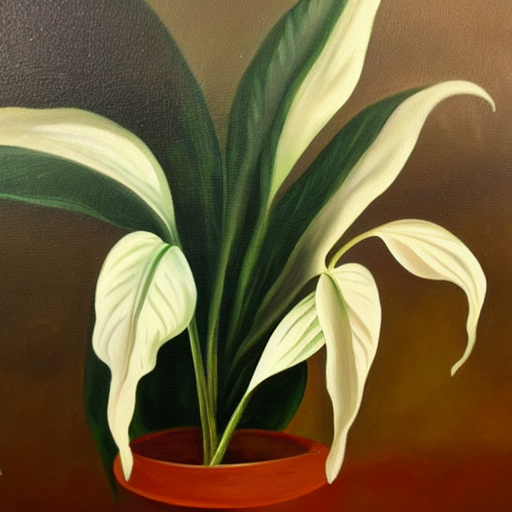

In [8]:
# Inference loop
with autocast("cuda"): # Reverts to CPU if there is no CUDA
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # Expand the latents if we are applying classifier free guidance to avoid two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    # Scale the latents (pre-conditioning)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents ## the scaling factor was implemented in the original paper.
with torch.no_grad():
  image = vae.decode(latents).sample

# Display output
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


## The Autoencoder (AE)

The AE is used to encode an image into some form of latent representation, and then decode this back into an image.

In [9]:
def pil_to_latent(input_im):
  # Single image to single latent in a batch
  with torch.no_grad():
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 - 1)
  # Scaling from before
  return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
  # batch of latents to list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy() # For reference permute consists of (bs, h, w, ch)
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [10]:
import os
os.chdir('/content/drive/MyDrive/Pic_samples/')
input_image = plt.imread('pasha.jpg')

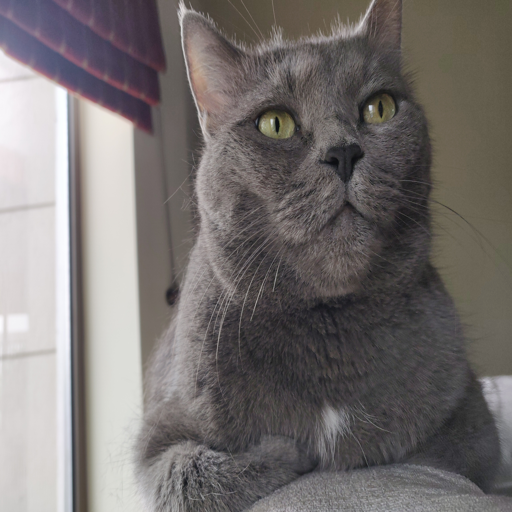

In [11]:
# Load the image
input_image = Image.open('pasha.jpg').resize((512, 512)) # Dimensions have to be a multiple of 8 to avoid errors
input_image

In [12]:
# Encoding to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

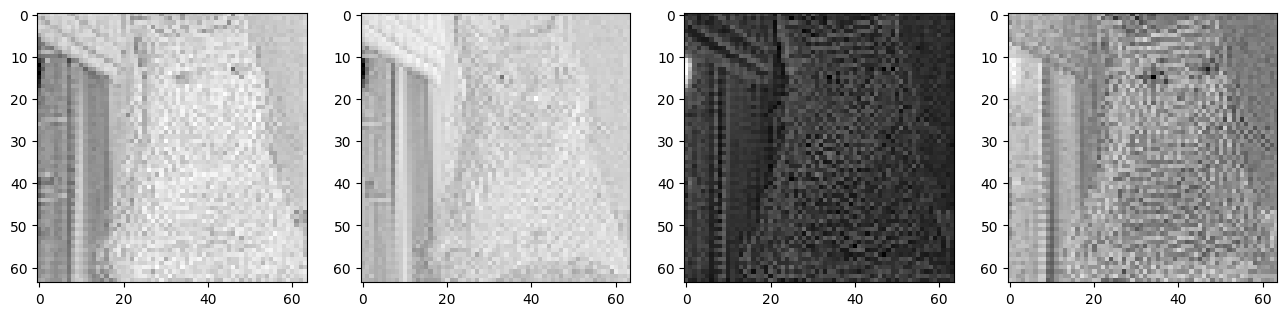

In [13]:
# Visualizing the channels
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
  axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

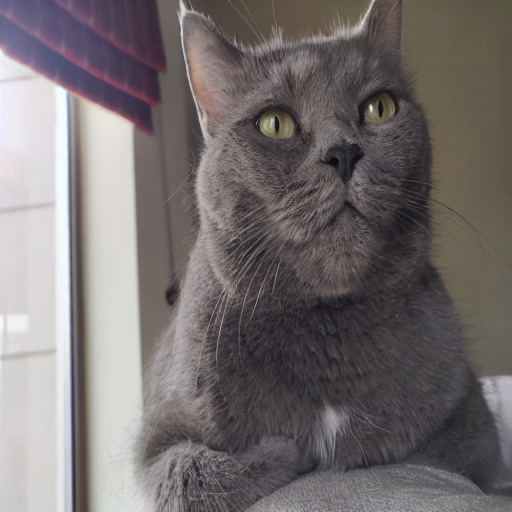

In [14]:
# Decoding the latent representation back to it's original format.
decoded = latents_to_pil(encoded)[0]
decoded

When taking a closer look at the decoded image (being a 4 x 4 x 64 latent), the addition of extra around detail in Pasha's retinas becomes apparent. There is also some additional shading around the whiskers and her chin. This seems to indicate that the latent holds more information than the input.

## The Scheduler

In this section, we will look at the process of adding noise during training and having the model predict the noise. Adding very little noise and, conversely, too much noise hinders the generation process because the model either has very little or too much information to work with.


In [15]:
# Setting number of sampling timesteps which are lower than the one used to train the
# model
set_timesteps(scheduler, 20)
print(scheduler.timesteps)

tensor([999.0000, 946.4211, 893.8421, 841.2632, 788.6842, 736.1053, 683.5263,
        630.9474, 578.3684, 525.7895, 473.2105, 420.6316, 368.0526, 315.4737,
        262.8947, 210.3158, 157.7368, 105.1579,  52.5789,   0.0000])


In [16]:
# These are the equivalent noise levels
print(scheduler.sigmas)

tensor([14.6146, 10.7469,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000])


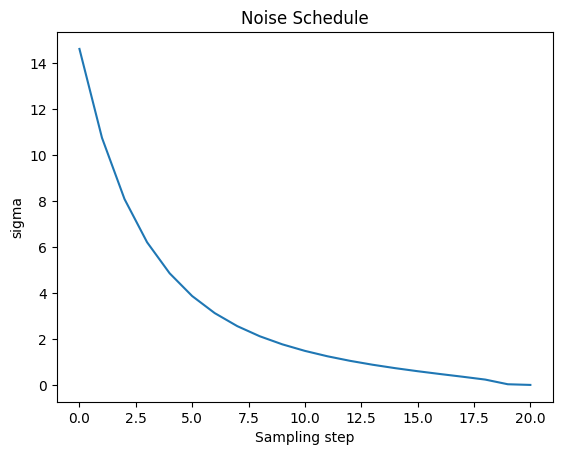

In [17]:
# Plotting the noise schedule
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

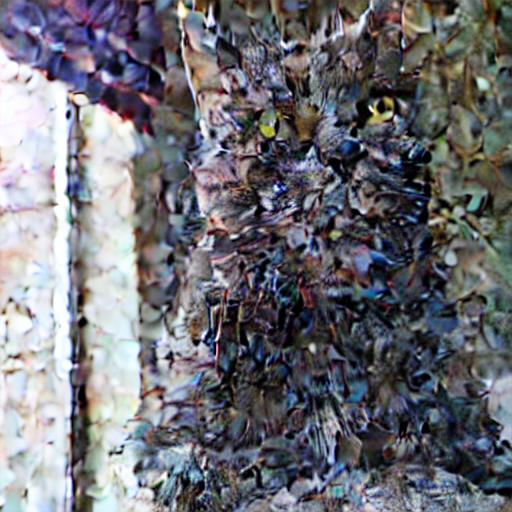

In [18]:
# Adding random noise into our encoded image
noise = torch.randn_like(encoded)
sampling_step = 15
encoded_and_noised = scheduler.add_noise(encoded,
                                          noise,
                                          timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
# Display noised image
latents_to_pil(encoded_and_noised.float())[0]


In [19]:
?? scheduler

## Loop Starts from Noised Version of Input **(ImagetoImage)**

  0%|          | 0/100 [00:00<?, ?it/s]

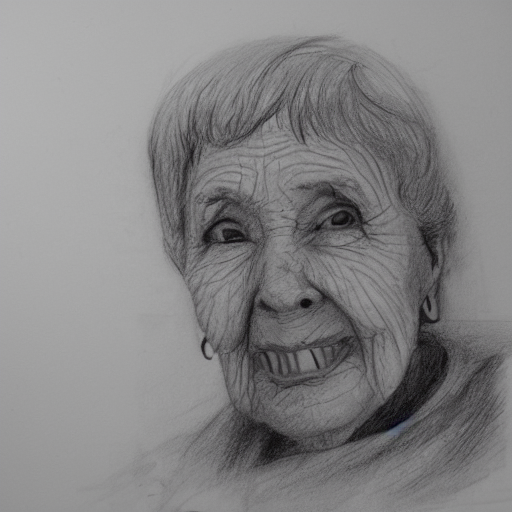

In [20]:
# Same settings as the previous loop except for the prompt
prompt = ["Old woman drinking tea, pencil sketch"]
height = 512
width = 512
num_inference_steps = 100
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1
# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                         truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# Prep scheduler
set_timesteps(scheduler, num_inference_steps)
# Prep latents
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()
# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
  if i >= start_step: # Modification to the loop
    # expand latents if we're doing classifire free guidance to avoid 2 forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    # Predict noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    # Compute previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Output
latents_to_pil(latents)[0]


Addings more noise and more steps will further separate the input image from the generated outputs.

## Text Embedding Pipeline

In [21]:
prompt = "A picture of a chainsaw"

# Tokenization
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
text_input['input_ids'][0]

tensor([49406,   320,  1674,   539,   320, 37617, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [22]:
# Individual tokens
# Taking the first 7 only
for t in text_input['input_ids'][0][:8]:
  print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(37617) chainsaw</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [23]:
# Output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape: ', output_embeddings.shape)
output_embeddings

Shape:  torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [ 1.1277, -0.4850,  0.4232,  ..., -0.0717, -1.2766,  0.1753],
         [ 1.1393, -0.4993,  0.4369,  ..., -0.0508, -1.2749,  0.1696],
         [ 1.0825, -0.3980,  0.5014,  ..., -0.0829, -1.2472,  0.1744]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [24]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

### Token Embeddings

In [25]:
# Here get_input_embeddings needs to combine token embeddings with
# position embeddings before they are used as inputs to the model.

# Access embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Gives vocab size and embedding dimensions

Embedding(49408, 768)

In [26]:
# Embed the token for cobra i.e. 21574
embedding = token_emb_layer(torch.tensor(21574, device=torch_device))
embedding.shape

torch.Size([768])

In [27]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape)
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [28]:
torch.Size

torch.Size

### Positional Embeddings

In [29]:
# These are optionally learnable parameters which tell the model the position of a token
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [30]:
# Getting position IDs
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### Combining Token and Position Embeddings

In [31]:
# We can now combine both types of embeddings before feeding through the transformer model
# It should be noted that this technique is specific for this model and there are number of
# other approaches as well.
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [32]:
# The results from the following are the same
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

### Feeding Through the Transformer Model

In [33]:
# Copying in the relevant sections from text_encoder.text_model.forward
# This will give us our last hidden state resulting in our final embeddings
def get_output_embeds(input_embeddings):
  # CLIP's text model uses causal mask
  bsz, seq_len = input_embeddings.shape[:2]
  causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len,
                                                                               dtype=input_embeddings.dtype)
  # Output embeddings can be returned when we pass output_hidden_states=True
  # This stops the model from returning the pooled final predictions
  encoder_outputs = text_encoder.text_model.encoder(
      inputs_embeds = input_embeddings,
      attention_mask=None,
      causal_attention_mask=causal_attention_mask.to(torch_device),
      output_attentions=None,
      output_hidden_states=True, # This give output embeddings instead of the final output
      return_dict=None,
  )
  # Getting output hidden state only
  output = encoder_outputs[0]
  # Final layer normalization which the output needs to be passed through
  output = text_encoder.text_model.final_layer_norm(output)
  return output

In [34]:
# Feeding the new embeddings through the model
out_embs_test = get_output_embeds(input_embeddings)
print(out_embs_test.shape) # Output shape
out_embs_test

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [ 1.1277, -0.4850,  0.4232,  ..., -0.0717, -1.2766,  0.1753],
         [ 1.1393, -0.4993,  0.4369,  ..., -0.0508, -1.2749,  0.1696],
         [ 1.0825, -0.3980,  0.5014,  ..., -0.0829, -1.2472,  0.1744]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

**Note on Attention and Causal Attention Masks**

_Source: ChatGPT_

    Attention Mask:
        1. The attention_mask is a standard attention mask used in transformer-based models.
        2. It is a binary mask that indicates which tokens should be attended to and which ones should be ignored.
        3. Typically, a value of 1 indicates that the token should be attended to, while a value of 0 indicates that it should be ignored.
        4. This mask is symmetric, meaning it allows the model to attend to both past and future tokens in the sequence.
        5. In the provided code snippet, attention_mask=None, indicating that no specific attention mask is being provided, and the model will attend to all tokens equally.

    Causal Attention Mask:
        1. The causal_attention_mask is a specific type of attention mask used in autoregressive models, such as those used in language generation tasks.
        2. It is also a binary mask but has a different structure compared to the standard attention mask.
        3. The causal attention mask ensures that each token can only attend to previous tokens in the sequence, preventing information leakage from future tokens during training or generation.
        4. It enforces the causality constraint, ensuring that the model generates sequences in an autoregressive manner, where each token is generated based only on previous tokens.
        5. In the provided code snippet, causal_attention_mask.to(torch_device) indicates that a causal attention mask is being used, and it is moved to the specified device (e.g., CPU or GPU) for computation.

In [35]:
# Getting the token of a word
prompt = 'drill'
print('tokenizer(prompt): ', tokenizer(prompt))
print('token_emb_layer([token_id]) shape: ', token_emb_layer(torch.tensor([8797], device=torch_device)).shape)

tokenizer(prompt):  {'input_ids': [49406, 11626, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape:  torch.Size([1, 768])


In [36]:
# Since our pipeline to replace embeddings is in place, let's replace the input embedding
# of a token with a new one of our choice - which will be learnt in our final use case.
prompt = 'A picture of a chainsaw'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding for token
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(11626, device=torch_device))

# Insert into token embeddings
token_embeddings[0, torch.where(input_ids[0]==37617)] = replacement_token_embedding.to(torch_device)

# Combine with positional embeddings
input_embeddings = token_embeddings + position_embeddings

# Feeding through final output embeddings
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.8703, -0.0980, -1.3130,  ...,  1.2629, -1.2520, -0.3782],
         [-0.8596, -0.1003, -1.2940,  ...,  1.2681, -1.2520, -0.3716],
         [-0.8473, -0.0275, -1.2762,  ...,  1.2997, -1.2282, -0.3807]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [37]:
# Our updated loop
def generate_with_embs(text_embeddings):
    height = 512
    width = 512
    num_inference_steps = 50
    guidance_scale = 7.5
    generator = torch.manual_seed(32)
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


<ipython-input-37-ed93e8e98f35>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

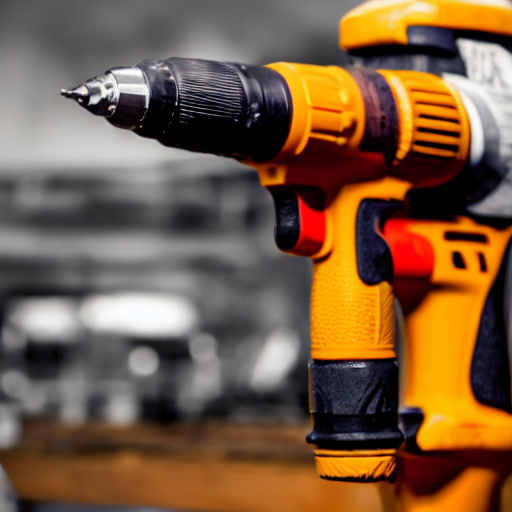

In [38]:
generate_with_embs(modified_output_embeddings)

We have effectively modified the token embeddings for `chainsaw` with those mapped to a `drill`. This is a simple method for modifying a model's vocabulary.

In [39]:
# Getting the token of a word
prompt ='sword'
print('tokenizer(prompt): ', tokenizer(prompt))
print('token_emb_layer([token_id]) shape: ', token_emb_layer(torch.tensor([8797], device=torch_device)).shape)

tokenizer(prompt):  {'input_ids': [49406, 11356, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape:  torch.Size([1, 768])


<ipython-input-37-ed93e8e98f35>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

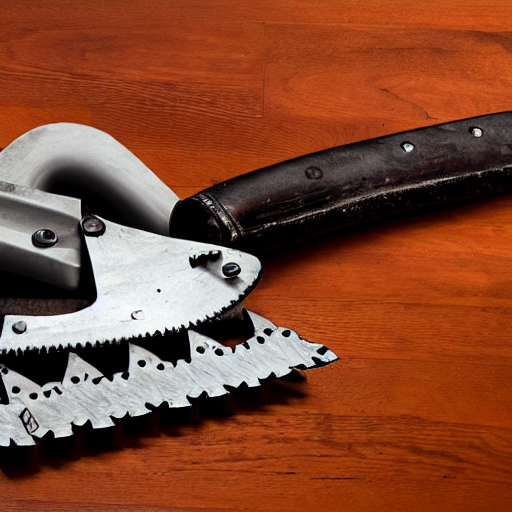

In [40]:
prompt = 'A picture of a chainsaw'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding will be a mixture of the embeddings for sword and chainsaw
# Why?? I can think of 40K reasons
chainsaw_token_embedding = token_emb_layer(torch.tensor(37617, device=torch_device))
sword_token_embedding = token_emb_layer(torch.tensor(11356, device=torch_device))
replacement_token_embedding = 0.70 * chainsaw_token_embedding  + 0.30 * sword_token_embedding

# Inserting into token embeddings
token_embeddings[0, torch.where(input_ids[0]==37617)] = replacement_token_embedding.to(torch_device)

# Combine with positional embeddings
input_embeddings = token_embeddings + position_embeddings

# Feed through for final output embeddings
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate image
generate_with_embs(modified_output_embeddings)

In [41]:
birb_embed = torch.load('/content/drive/MyDrive/Learned_Embs/learned_embeds.bin') # Temp upload
birb_embed.keys(), birb_embed['<birb-style>'].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

<ipython-input-37-ed93e8e98f35>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

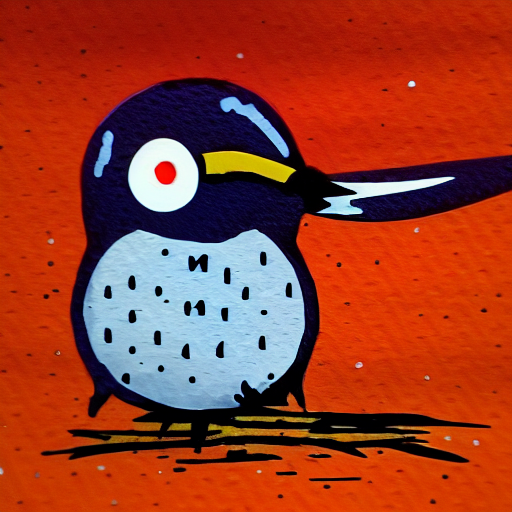

In [42]:
prompt = 'A chainsaw in the style of sword'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==11356)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

### Further Tinkering with Embeddings


<ipython-input-37-ed93e8e98f35>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

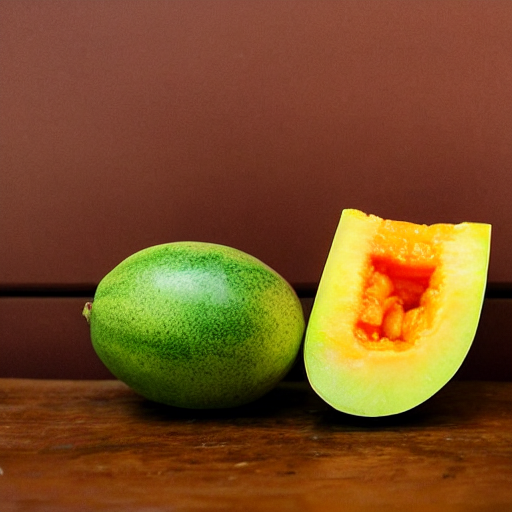

In [43]:
# Embed two prompts
text_input1 = tokenizer(["A Mango"], padding="max_length", max_length=tokenizer.model_max_length,
                        truncation=True, return_tensors="pt")
text_input2 = tokenizer(["A Watermelon"], padding="max_length", max_length=tokenizer.model_max_length,
                        truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
    text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]

# Mix them together
mix_factor = 0.65
mixed_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))

# Generate
generate_with_embs(mixed_embeddings)

## A Closer Inspection of the UNET and CFG

We will be taking a closer look at the diffusion model itself. What must be remembered is that:
1. The model is based on a UNet which takes in the noisy latents and predicts the noise.
2. This is a conditional model that takes in the timestep (t) as well as our text embedding (encoder hidden states) as conditioning.

In [44]:
# Generating the output sample
# Prep scheduler
set_timesteps(scheduler, num_inference_steps)

# The timestep
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

# A noisy latent
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Text embedding
text_input = tokenizer(['A falcon'], padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Running through the UNet to predict the noise residual
with torch.no_grad():
  noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]

latents.shape, noise_pred.shape

<ipython-input-44-7d824966ac55>:11: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

Given a set of noisy latents:
1. The model predicts the noise component.
2. The noise can be removed from the noisy latents to see the output image.
3. Most of the noise can be added back in to the predicted output to get a slightly less noisy input (_which is not always guaranteed given the probabilistic nature of these models_) for the next diffusion step.

Visualizing the process will help us understand this better.

In [45]:
# This step will take longer since images are first decoded and then saved in the folders below
prompt = "A diamond refracting light"
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 9
generator = torch.manual_seed(44)
batch_size = 1

# Folder to store these results
!rm -rf /content/steps/
!mkdir -p /content/steps/

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Training loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
  # Expand latents if using classifier free guidance to avoid 2 forward passes.
  latent_model_input = torch.cat([latents] * 2)
  sigma = scheduler.sigmas[i]
  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # Predict noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Get predicted x0:
  # This can be gotten manually by --> latents_x0 = latents - sigma * noise_pred
  # But we will use the scheduler instead.
  scheduler_step = scheduler.step(noise_pred, t, latents)
  latents_x0 = scheduler_step.pred_original_sample

  # Compute previous noisy sample
  latents = scheduler_step.prev_sample

  # To PIL img
  im_t0 = latents_to_pil(latents_x0)[0]
  im_next = latents_to_pil(latents)[0]

  # Combine the images and save for later viewing
  im = Image.new('RGB', (1024, 512))
  im.paste(im_next, (0, 0))
  im.paste(im_t0, (512, 0))
  im.save(f'steps/{i:04}.jpeg')

<ipython-input-45-02b8b40d5410>:32: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
# Make and show progress video
!!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4

mp4 = open('out.mp4', 'rb').read()
data_url = "data:video/mp4; base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Guidance

In [47]:
def blue_loss(images):
  # How far are the blue channel values to 0.9
  # Returns all images in the batch, blue channel only
  error = torch.abs(images[:, 2] - 0.9).mean()
  return error

<ipython-input-54-82258129e5c7>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 170.73428344726562
10 loss 53.76139831542969
20 loss 33.54537582397461
30 loss 29.833120346069336
40 loss 27.982196807861328


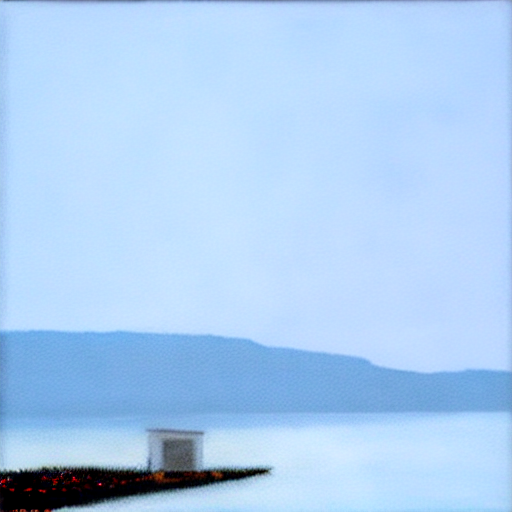

In [54]:
# We'll also add inputs this time around
prompt = 'A cabin by the lake (oil on canvas)' #@param
height = 512
width = 512
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(44)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 250 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    ## Additional guidance once every 5 iterations to save time and compute
    ## resources.
    if i%5 == 0:
      # Requires grad on the latents for more accurate gradients
      # This requires more memory
      latents = latents.detach().requires_grad_()

      # Get  predicted x0:
      latents_x0 = latents - sigma * noise_pred

      # Decode to image space
      denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5

      # Calculate loss
      loss = blue_loss(denoised_images) * blue_loss_scale

      # Print outs after certain number of steps
      if i%10 == 0:
        print(i, 'loss', loss.item())

      # Get gradient
      cond_grad = torch.autograd.grad(loss, latents)[0]

      # Modify the latents based on the gradients
      latents = latents.detach() - cond_grad * sigma ** 2

    # Carry out steps with the scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]